# Golden Cross Scanner & Backtester — Confirmation-Filtered CSV (RSI/MACD) & Full-Capital Trades

**Dependencies (install if needed):**
```bash
pip install pandas numpy yfinance matplotlib
```

## What's New in this Version
- The **signals CSV** (`output/goldencross_signals.csv`) now **includes and is filtered by** the selected confirmation (RSI or MACD). Only signals passing the chosen confirmation are saved.
- Extra columns added to the CSV for transparency: `confirmation_type`, `confirm_pass`, and `confirm_detail`.
- Backtest uses **100% of available capital** per trade; **one position at a time**.

## Strategy Summary
- **Signal**: 50-day SMA crosses **above** 200-day SMA on day *t*.
- **Confirmation** (industry defaults):
  - **MACD(12,26,9)**: require `MACD > Signal` **and** `Histogram[t] > Histogram[t-1]`.
  - **RSI(14)**: require `RSI > 50` **and** `RSI[t] > RSI[t-1]`.
- **Entry**: Next trading day's **Open** (fallback to next **Close** if Open is missing).
- **Exits** (earliest of): Death cross (next open), ATR(14) trailing stop (optional), hard stop (optional), max-hold days (at close).
- **Valuation**: Execution uses **unadjusted** OHLC; daily portfolio uses **Adjusted Close** for corporate actions.


In [17]:
# ============================
# Configurable Parameters
# ============================
TICKERS = ['360ONE.NS', '3MINDIA.NS', 'ABB.NS', 'ACC.NS', 'ACMESOLAR.NS', 'AIAENG.NS', 'APLAPOLLO.NS', 'AUBANK.NS', 'AWL.NS', 'AADHARHFC.NS', 'AARTIIND.NS', 'AAVAS.NS', 'ABBOTINDIA.NS', 'ACE.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIPOWER.NS', 'ATGL.NS', 'ABCAPITAL.NS', 'ABFRL.NS', 'ABREL.NS', 'ABSLAMC.NS', 'AEGISLOG.NS', 'AFCONS.NS', 'AFFLE.NS', 'AJANTPHARM.NS', 'AKUMS.NS', 'APLLTD.NS', 'ALIVUS.NS', 'ALKEM.NS', 'ALKYLAMINE.NS', 'ALOKINDS.NS', 'ARE&M.NS', 'AMBER.NS', 'AMBUJACEM.NS', 'ANANDRATHI.NS', 'ANANTRAJ.NS', 'ANGELONE.NS', 'APARINDS.NS', 'APOLLOHOSP.NS', 'APOLLOTYRE.NS', 'APTUS.NS', 'ASAHIINDIA.NS', 'ASHOKLEY.NS', 'ASIANPAINT.NS', 'ASTERDM.NS', 'ASTRAZEN.NS', 'ASTRAL.NS', 'ATUL.NS', 'AUROPHARMA.NS', 'AIIL.NS', 'DMART.NS', 'AXISBANK.NS', 'BASF.NS', 'BEML.NS', 'BLS.NS', 'BSE.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS', 'BAJAJHFL.NS', 'BALKRISIND.NS', 'BALRAMCHIN.NS', 'BANDHANBNK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'MAHABANK.NS', 'BATAINDIA.NS', 'BAYERCROP.NS', 'BERGEPAINT.NS', 'BDL.NS', 'BEL.NS', 'BHARATFORG.NS', 'BHEL.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BHARTIHEXA.NS', 'BIKAJI.NS', 'BIOCON.NS', 'BSOFT.NS', 'BLUEDART.NS', 'BLUESTARCO.NS', 'BBTC.NS', 'BOSCHLTD.NS', 'FIRSTCRY.NS', 'BRIGADE.NS', 'BRITANNIA.NS', 'MAPMYINDIA.NS', 'CCL.NS', 'CESC.NS', 'CGPOWER.NS', 'CRISIL.NS', 'CAMPUS.NS', 'CANFINHOME.NS', 'CANBK.NS', 'CAPLIPOINT.NS', 'CGCL.NS', 'CARBORUNIV.NS', 'CASTROLIND.NS', 'CEATLTD.NS', 'CENTRALBK.NS', 'CDSL.NS', 'CENTURYPLY.NS', 'CERA.NS', 'CHALET.NS', 'CHAMBLFERT.NS', 'CHENNPETRO.NS', 'CHOLAHLDNG.NS', 'CHOLAFIN.NS', 'CIPLA.NS', 'CUB.NS', 'CLEAN.NS', 'COALINDIA.NS', 'COCHINSHIP.NS', 'COFORGE.NS', 'COHANCE.NS', 'COLPAL.NS', 'CAMS.NS', 'CONCORDBIO.NS', 'CONCOR.NS', 'COROMANDEL.NS', 'CRAFTSMAN.NS', 'CREDITACC.NS', 'CROMPTON.NS', 'CUMMINSIND.NS', 'CYIENT.NS', 'DCMSHRIRAM.NS', 'DLF.NS', 'DOMS.NS', 'DABUR.NS', 'DALBHARAT.NS', 'DATAPATTNS.NS', 'DEEPAKFERT.NS', 'DEEPAKNTR.NS', 'DELHIVERY.NS', 'DEVYANI.NS', 'DIVISLAB.NS', 'DIXON.NS', 'LALPATHLAB.NS', 'DRREDDY.NS', 'EIDPARRY.NS', 'EIHOTEL.NS', 'EICHERMOT.NS', 'ELECON.NS', 'ELGIEQUIP.NS', 'EMAMILTD.NS', 'EMCURE.NS', 'ENDURANCE.NS', 'ENGINERSIN.NS', 'ERIS.NS', 'ESCORTS.NS', 'ETERNAL.NS', 'EXIDEIND.NS', 'NYKAA.NS', 'FEDERALBNK.NS', 'FACT.NS', 'FINCABLES.NS', 'FINPIPE.NS', 'FSL.NS', 'FIVESTAR.NS', 'FORTIS.NS', 'GAIL.NS', 'GVT&D.NS', 'GMRAIRPORT.NS', 'GRSE.NS', 'GICRE.NS', 'GILLETTE.NS', 'GLAND.NS', 'GLAXO.NS', 'GLENMARK.NS', 'MEDANTA.NS', 'GODIGIT.NS', 'GPIL.NS', 'GODFRYPHLP.NS', 'GODREJAGRO.NS', 'GODREJCP.NS', 'GODREJIND.NS', 'GODREJPROP.NS', 'GRANULES.NS', 'GRAPHITE.NS', 'GRASIM.NS', 'GRAVITA.NS', 'GESHIP.NS', 'FLUOROCHEM.NS', 'GUJGASLTD.NS', 'GMDCLTD.NS', 'GNFC.NS', 'GPPL.NS', 'GSPL.NS', 'HEG.NS', 'HBLENGINE.NS', 'HCLTECH.NS', 'HDFCAMC.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HFCL.NS', 'HAPPSTMNDS.NS', 'HAVELLS.NS', 'HEROMOTOCO.NS', 'HSCL.NS', 'HINDALCO.NS', 'HAL.NS', 'HINDCOPPER.NS', 'HINDPETRO.NS', 'HINDUNILVR.NS', 'HINDZINC.NS', 'POWERINDIA.NS', 'HOMEFIRST.NS', 'HONASA.NS', 'HONAUT.NS', 'HUDCO.NS', 'HYUNDAI.NS', 'ICICIBANK.NS', 'ICICIGI.NS', 'ICICIPRULI.NS', 'IDBI.NS', 'IDFCFIRSTB.NS', 'IFCI.NS', 'IIFL.NS', 'INOXINDIA.NS', 'IRB.NS', 'IRCON.NS', 'ITC.NS', 'ITI.NS', 'INDGN.NS', 'INDIACEM.NS', 'INDIAMART.NS', 'INDIANB.NS', 'IEX.NS', 'INDHOTEL.NS', 'IOC.NS', 'IOB.NS', 'IRCTC.NS', 'IRFC.NS', 'IREDA.NS', 'IGL.NS', 'INDUSTOWER.NS', 'INDUSINDBK.NS', 'NAUKRI.NS', 'INFY.NS', 'INOXWIND.NS', 'INTELLECT.NS', 'INDIGO.NS', 'IGIL.NS', 'IKS.NS', 'IPCALAB.NS', 'JBCHEPHARM.NS', 'JKCEMENT.NS', 'JBMA.NS', 'JKTYRE.NS', 'JMFINANCIL.NS', 'JSWENERGY.NS', 'JSWHL.NS', 'JSWINFRA.NS', 'JSWSTEEL.NS', 'JPPOWER.NS', 'J&KBANK.NS', 'JINDALSAW.NS', 'JSL.NS', 'JINDALSTEL.NS', 'JIOFIN.NS', 'JUBLFOOD.NS', 'JUBLINGREA.NS', 'JUBLPHARMA.NS', 'JWL.NS', 'JUSTDIAL.NS', 'JYOTHYLAB.NS', 'JYOTICNC.NS', 'KPRMILL.NS', 'KEI.NS', 'KNRCON.NS', 'KPITTECH.NS', 'KAJARIACER.NS', 'KPIL.NS', 'KALYANKJIL.NS', 'KANSAINER.NS', 'KARURVYSYA.NS', 'KAYNES.NS', 'KEC.NS', 'KFINTECH.NS', 'KIRLOSBROS.NS', 'KIRLOSENG.NS', 'KOTAKBANK.NS', 'KIMS.NS', 'LTF.NS', 'LTTS.NS', 'LICHSGFIN.NS', 'LTFOODS.NS', 'LTIM.NS', 'LT.NS', 'LATENTVIEW.NS', 'LAURUSLABS.NS', 'LEMONTREE.NS', 'LICI.NS', 'LINDEINDIA.NS', 'LLOYDSME.NS', 'LODHA.NS', 'LUPIN.NS', 'MMTC.NS', 'MRF.NS', 'MGL.NS', 'MAHSEAMLES.NS', 'M&MFIN.NS', 'M&M.NS', 'MANAPPURAM.NS', 'MRPL.NS', 'MANKIND.NS', 'MARICO.NS', 'MARUTI.NS', 'MASTEK.NS', 'MFSL.NS', 'MAXHEALTH.NS', 'MAZDOCK.NS', 'METROPOLIS.NS', 'MINDACORP.NS', 'MSUMI.NS', 'MOTILALOFS.NS', 'MPHASIS.NS', 'MCX.NS', 'MUTHOOTFIN.NS', 'NATCOPHARM.NS', 'NBCC.NS', 'NCC.NS', 'NHPC.NS', 'NLCINDIA.NS', 'NMDC.NS', 'NSLNISP.NS', 'NTPCGREEN.NS', 'NTPC.NS', 'NH.NS', 'NATIONALUM.NS', 'NAVA.NS', 'NAVINFLUOR.NS', 'NESTLEIND.NS', 'NETWEB.NS', 'NETWORK18.NS', 'NEULANDLAB.NS', 'NEWGEN.NS', 'NAM-INDIA.NS', 'NIVABUPA.NS', 'NUVAMA.NS', 'OBEROIRLTY.NS', 'ONGC.NS', 'OIL.NS', 'OLAELEC.NS', 'OLECTRA.NS', 'PAYTM.NS', 'OFSS.NS', 'POLICYBZR.NS', 'PCBL.NS', 'PGEL.NS', 'PIIND.NS', 'PNBHOUSING.NS', 'PNCINFRA.NS', 'PTCIL.NS', 'PVRINOX.NS', 'PAGEIND.NS', 'PATANJALI.NS', 'PERSISTENT.NS', 'PETRONET.NS', 'PFIZER.NS', 'PHOENIXLTD.NS', 'PIDILITIND.NS', 'PEL.NS', 'PPLPHARMA.NS', 'POLYMED.NS', 'POLYCAB.NS', 'POONAWALLA.NS', 'PFC.NS', 'POWERGRID.NS', 'PRAJIND.NS', 'PREMIERENE.NS', 'PRESTIGE.NS', 'PNB.NS', 'RRKABEL.NS', 'RBLBANK.NS', 'RECLTD.NS', 'RHIM.NS', 'RITES.NS', 'RADICO.NS', 'RVNL.NS', 'RAILTEL.NS', 'RAINBOW.NS', 'RKFORGE.NS', 'RCF.NS', 'RTNINDIA.NS', 'RAYMONDLSL.NS', 'RAYMOND.NS', 'REDINGTON.NS', 'RELIANCE.NS', 'RPOWER.NS', 'ROUTE.NS', 'SBFC.NS', 'SBICARD.NS', 'SBILIFE.NS', 'SJVN.NS', 'SKFINDIA.NS', 'SRF.NS', 'SAGILITY.NS', 'SAILIFE.NS', 'SAMMAANCAP.NS', 'MOTHERSON.NS', 'SAPPHIRE.NS', 'SARDAEN.NS', 'SAREGAMA.NS', 'SCHAEFFLER.NS', 'SCHNEIDER.NS', 'SCI.NS', 'SHREECEM.NS', 'RENUKA.NS', 'SHRIRAMFIN.NS', 'SHYAMMETL.NS', 'SIEMENS.NS', 'SIGNATURE.NS', 'SOBHA.NS', 'SOLARINDS.NS', 'SONACOMS.NS', 'SONATSOFTW.NS', 'STARHEALTH.NS', 'SBIN.NS', 'SAIL.NS', 'SWSOLAR.NS', 'SUMICHEM.NS', 'SUNPHARMA.NS', 'SUNTV.NS', 'SUNDARMFIN.NS', 'SUNDRMFAST.NS', 'SUPREMEIND.NS', 'SUZLON.NS', 'SWANCORP.NS', 'SWIGGY.NS', 'SYNGENE.NS', 'SYRMA.NS', 'TBOTEK.NS', 'TVSMOTOR.NS', 'TANLA.NS', 'TATACHEM.NS', 'TATACOMM.NS', 'TCS.NS', 'TATACONSUM.NS', 'TATAELXSI.NS', 'TATAINVEST.NS', 'TATAMOTORS.NS', 'TATAPOWER.NS', 'TATASTEEL.NS', 'TATATECH.NS', 'TTML.NS', 'TECHM.NS', 'TECHNOE.NS', 'TEJASNET.NS', 'NIACL.NS', 'RAMCOCEM.NS', 'THERMAX.NS', 'TIMKEN.NS', 'TITAGARH.NS', 'TITAN.NS', 'TORNTPHARM.NS', 'TORNTPOWER.NS', 'TARIL.NS', 'TRENT.NS', 'TRIDENT.NS', 'TRIVENI.NS', 'TRITURBINE.NS', 'TIINDIA.NS', 'UCOBANK.NS', 'UNOMINDA.NS', 'UPL.NS', 'UTIAMC.NS', 'ULTRACEMCO.NS', 'UNIONBANK.NS', 'UBL.NS', 'UNITDSPR.NS', 'USHAMART.NS', 'VGUARD.NS', 'DBREALTY.NS', 'VTL.NS', 'VBL.NS', 'MANYAVAR.NS', 'VEDL.NS', 'VIJAYA.NS', 'VMM.NS', 'IDEA.NS', 'VOLTAS.NS', 'WAAREEENER.NS', 'WELCORP.NS', 'WELSPUNLIV.NS', 'WESTLIFE.NS', 'WHIRLPOOL.NS', 'WIPRO.NS', 'WOCKPHARMA.NS', 'YESBANK.NS', 'ZFCVINDIA.NS', 'ZEEL.NS', 'ZENTEC.NS', 'ZENSARTECH.NS', 'ZYDUSLIFE.NS', 'ECLERX.NS']

START_DATE = "2020-01-01"
END_DATE   = "2025-09-09"

FAST_WINDOW = 50
SLOW_WINDOW = 200
TIMEFRAME   = "1d"

# Confirmation: choose 'MACD', 'RSI', or 'NONE'
CONFIRMATION_TYPE = "RSI"
RSI_WINDOW  = 14
MACD_FAST   = 12
MACD_SLOW   = 26
MACD_SIGNAL = 9

# Capital & Sizing: FULL CAPITAL; one position at a time
INITIAL_CAPITAL      = 100000.0
SLIPPAGE_PCT         = 0.0005   # 5 bps per entry/exit
COMMISSION_PER_TRADE = 0.0

# Exits
MAX_HOLD_DAYS            = 30
USE_TRAILING_STOP        = True
TRAILING_ATR_MULTIPLIER  = 3.0
ATR_WINDOW               = 14
USE_HARD_STOP            = True
HARD_STOP_PCT            = 0.10

# Outputs
OUTPUT_DIR = "output"
OUTPUT_SIGNALS_CSV       = f"{OUTPUT_DIR}/goldencross_signals.csv"
OUTPUT_BACKTEST_CSV      = f"{OUTPUT_DIR}/goldencross_backtest_results.csv"
OUTPUT_EQUITY_CURVE_CSV  = f"{OUTPUT_DIR}/equity_curve.csv"
import os; os.makedirs(OUTPUT_DIR, exist_ok=True)


In [18]:
from __future__ import annotations
import math, logging
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datetime import timedelta

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s", datefmt="%H:%M:%S")
logger = logging.getLogger("gc_notebook")


## Indicator Helpers (SMA, ATR, RSI, MACD)
Implemented with pandas to avoid external TA packages.

In [19]:
def _to_dt_index(df: pd.DataFrame) -> pd.DataFrame:
    idx = pd.to_datetime(df.index)
    if idx.tz is not None:
        idx = idx.tz_localize(None)
    out = df.copy(); out.index = idx
    return out

def fetch_data(ticker: str, start: str, end: str, interval: str = "1d") -> Optional[pd.DataFrame]:
    try:
        df = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=False, progress=False, threads=True, multi_level_index=False)
        if df is None or df.empty:
            logger.warning(f"{ticker}: No data returned.")
            return None
        df = _to_dt_index(df)
        expected = ["Open","High","Low","Close","Adj Close","Volume"]
        for c in expected:
            if c not in df.columns:
                df[c] = np.nan
        return df[expected].dropna(how="all")
    except Exception as e:
        logger.error(f"Failed to fetch {ticker}: {e}")
        return None

def rsi(series: pd.Series, window: int = 14) -> pd.Series:
    delta = series.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    avg_gain = up.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    avg_loss = down.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def macd(series: pd.Series, fast: int = 12, slow: int = 26, signal: int = 9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def compute_indicators(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["FAST_SMA"] = out["Close"].rolling(window=FAST_WINDOW, min_periods=FAST_WINDOW).mean()
    out["SLOW_SMA"] = out["Close"].rolling(window=SLOW_WINDOW, min_periods=SLOW_WINDOW).mean()
    # ATR(14)
    prev_close = out["Close"].shift(1)
    tr1 = out["High"] - out["Low"]
    tr2 = (out["High"] - prev_close).abs()
    tr3 = (out["Low"] - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    out["ATR"] = tr.rolling(window=ATR_WINDOW, min_periods=ATR_WINDOW).mean()
    # RSI & MACD
    out["RSI"] = rsi(out["Close"], RSI_WINDOW)
    out["MACD"], out["MACD_SIGNAL"], out["MACD_HIST"] = macd(out["Close"], MACD_FAST, MACD_SLOW, MACD_SIGNAL)
    return out


## Signal Detection (with Confirmation)
We record confirmation details for the CSV. Only **confirmed** signals are returned/saved.

In [20]:
@dataclass
class Signal:
    ticker: str
    signal_date: pd.Timestamp
    entry_date: Optional[pd.Timestamp]
    entry_price: Optional[float]
    fast_sma: float
    slow_sma: float
    atr: Optional[float]
    confirmation_type: str = "NONE"
    confirm_pass: bool = False
    confirm_detail: str = ""  # JSON-ish text for transparency
    notes: str = ""

import json as _json

def _confirmation_details(df: pd.DataFrame, t: pd.Timestamp) -> Tuple[bool, dict]:
    ctype = CONFIRMATION_TYPE.upper()
    if ctype == "MACD":
        macd_val   = df.at[t, "MACD"] if t in df.index else np.nan
        signal_val = df.at[t, "MACD_SIGNAL"] if t in df.index else np.nan
        hist_t     = df.at[t, "MACD_HIST"] if t in df.index else np.nan
        hist_tm1   = df["MACD_HIST"].shift(1).loc[t] if t in df.index else np.nan
        cond1 = (macd_val > signal_val) if not (pd.isna(macd_val) or pd.isna(signal_val)) else False
        cond2 = (hist_t > hist_tm1) if not (pd.isna(hist_t) or pd.isna(hist_tm1)) else False
        passed = bool(cond1 and cond2)
        return passed, {"MACD": float(macd_val) if not pd.isna(macd_val) else None,
                        "Signal": float(signal_val) if not pd.isna(signal_val) else None,
                        "Hist_t": float(hist_t) if not pd.isna(hist_t) else None,
                        "Hist_t-1": float(hist_tm1) if not pd.isna(hist_tm1) else None,
                        "cond_macd_gt_signal": bool(cond1),
                        "cond_hist_rising": bool(cond2)}
    elif ctype == "RSI":
        rsi_t   = df.at[t, "RSI"] if t in df.index else np.nan
        rsi_tm1 = df["RSI"].shift(1).loc[t] if t in df.index else np.nan
        cond1 = (rsi_t > 50) if not pd.isna(rsi_t) else False
        cond2 = (rsi_t > rsi_tm1) if not (pd.isna(rsi_t) or pd.isna(rsi_tm1)) else False
        passed = bool(cond1 and cond2)
        return passed, {"RSI_t": float(rsi_t) if not pd.isna(rsi_t) else None,
                        "RSI_t-1": float(rsi_tm1) if not pd.isna(rsi_tm1) else None,
                        "cond_rsi_gt_50": bool(cond1),
                        "cond_rsi_rising": bool(cond2)}
    else:
        return True, {"note": "No confirmation filter (NONE)"}

def detect_golden_crosses(df: pd.DataFrame, ticker: str) -> List[Signal]:
    out: List[Signal] = []
    cond_today = df["FAST_SMA"] > df["SLOW_SMA"]
    cond_yday  = df["FAST_SMA"].shift(1) <= df["SLOW_SMA"].shift(1)
    cross_idx = df.index[cond_today & cond_yday]
    for t in cross_idx:
        if pd.isna(df.at[t, "FAST_SMA"]) or pd.isna(df.at[t, "SLOW_SMA"]):
            continue
        passed, details = _confirmation_details(df, t)
        if not passed:
            continue  # filter out unconfirmed
        # find next trading day for entry
        all_dates = df.index
        loc = all_dates.get_loc(t)
        if isinstance(loc, slice):
            continue
        next_pos = loc + 1
        if next_pos >= len(all_dates):
            out.append(Signal(ticker, t, None, None,
                               float(df.at[t, "FAST_SMA"]), float(df.at[t, "SLOW_SMA"]),
                               float(df.at[t, "ATR"]) if not pd.isna(df.at[t, "ATR"]) else None,
                               confirmation_type=CONFIRMATION_TYPE,
                               confirm_pass=True,
                               confirm_detail=_json.dumps(details),
                               notes="No next day available for entry"))
            continue
        entry_day = all_dates[next_pos]
        open_px = df.at[entry_day, "Open"]
        if pd.isna(open_px) or open_px <= 0:
            close_px = df.at[entry_day, "Close"]
            if pd.isna(close_px) or close_px <= 0:
                out.append(Signal(ticker, t, None, None,
                                   float(df.at[t, "FAST_SMA"]), float(df.at[t, "SLOW_SMA"]),
                                   float(df.at[t, "ATR"]) if not pd.isna(df.at[t, "ATR"]) else None,
                                   confirmation_type=CONFIRMATION_TYPE,
                                   confirm_pass=True,
                                   confirm_detail=_json.dumps(details),
                                   notes="Next open/close invalid"))
                continue
            entry_price = float(close_px); notes = "Next open missing -> entry at next close"
        else:
            entry_price = float(open_px); notes = "Entry at next open"
        out.append(Signal(ticker, t, entry_day, entry_price,
                           float(df.at[t, "FAST_SMA"]), float(df.at[t, "SLOW_SMA"]),
                           float(df.at[t, "ATR"]) if not pd.isna(df.at[t, "ATR"]) else None,
                           confirmation_type=CONFIRMATION_TYPE,
                           confirm_pass=True,
                           confirm_detail=_json.dumps(details),
                           notes=notes))
    return out

def detect_death_cross_dates(df: pd.DataFrame) -> pd.DatetimeIndex:
    cond_today = df["FAST_SMA"] < df["SLOW_SMA"]
    cond_yday  = df["FAST_SMA"].shift(1) >= df["SLOW_SMA"].shift(1)
    return df.index[cond_today & cond_yday]


## Backtest (Full Capital, Single Position)
Enter with **all available cash**, ignore new entries while invested, and exit on the earliest rule.

In [21]:
def save_signals_csv(signals: List[Signal], out_path: str):
    rows = []
    for s in signals:
        rows.append({
            "ticker": s.ticker,
            "signal_date": s.signal_date.strftime("%Y-%m-%d") if pd.notna(s.signal_date) else "",
            "entry_date": s.entry_date.strftime("%Y-%m-%d") if s.entry_date is not None else "",
            "entry_price": round(s.entry_price, 6) if s.entry_price is not None else "",
            "fast_sma": round(s.fast_sma, 6) if s.fast_sma is not None else "",
            "slow_sma": round(s.slow_sma, 6) if s.slow_sma is not None else "",
            "atr": round(s.atr, 6) if s.atr is not None else "",
            "confirmation_type": s.confirmation_type,
            "confirm_pass": s.confirm_pass,
            "confirm_detail": s.confirm_detail,
            "notes": s.notes or "",
        })
    pd.DataFrame(rows).to_csv(out_path, index=False)

def apply_slippage(price: float, is_buy: bool, slippage_pct: float) -> float:
    if pd.isna(price) or price <= 0:
        return np.nan
    if not slippage_pct:
        return float(price)
    return float(price) * (1.0 + slippage_pct) if is_buy else float(price) * (1.0 - slippage_pct)

def first_next_trading_day(df: pd.DataFrame, day: pd.Timestamp) -> Optional[pd.Timestamp]:
    if day not in df.index:
        idx = df.index.searchsorted(day)
    else:
        idx = df.index.get_loc(day)
        if isinstance(idx, slice):
            idx = idx.start
        idx += 1
    if idx >= len(df.index):
        return None
    return df.index[idx]

@dataclass
class Position:
    ticker: str
    entry_date: pd.Timestamp
    entry_price_exec: float
    shares: int
    highest_close_since_entry: float
    trailing_stop: Optional[float]
    hard_stop: Optional[float]
    max_hold_exit_date: Optional[pd.Timestamp]
    scheduled_exit_next_open: Optional[Tuple[pd.Timestamp, str]] = None
    scheduled_exit_at_close: Optional[Tuple[pd.Timestamp, str]] = None

@dataclass
class TradeResult:
    ticker: str
    entry_date: pd.Timestamp
    entry_price: float
    exit_date: pd.Timestamp
    exit_price: float
    shares: int
    pnl: float
    return_pct: float
    days_held: int
    reason: str

def backtest_signals(signals: List[Signal], price_data: Dict[str, pd.DataFrame]) -> Tuple[pd.DataFrame, pd.DataFrame, List[TradeResult]]:
    signals = [s for s in signals if (s.ticker in price_data and s.entry_date is not None and s.entry_price is not None)]
    signals.sort(key=lambda x: (x.entry_date, x.ticker))
    death_cross_map = {tkr: detect_death_cross_dates(df) for tkr, df in price_data.items()}
    all_dates = sorted(set().union(*[df.index.tolist() for df in price_data.values()]))
    calendar = pd.DatetimeIndex(all_dates)

    cash = float(INITIAL_CAPITAL)
    position: Optional[Position] = None
    trades: List[TradeResult] = []
    entries_by_date: Dict[pd.Timestamp, List[Signal]] = {}
    for s in signals:
        entries_by_date.setdefault(s.entry_date, []).append(s)
    equity_rows = []

    for day in calendar:
        # 1) Exit at next open
        if position and position.scheduled_exit_next_open and position.scheduled_exit_next_open[0] == day:
            dfp = price_data[position.ticker]
            if day in dfp.index:
                px = dfp.at[day, "Open"]
                if pd.isna(px) or px <= 0:
                    px = dfp.at[day, "Close"]
                exec_px = apply_slippage(px, is_buy=False, slippage_pct=SLIPPAGE_PCT)
                cash += exec_px * position.shares - COMMISSION_PER_TRADE
                pnl = (exec_px - position.entry_price_exec) * position.shares - COMMISSION_PER_TRADE
                ret = (exec_px / position.entry_price_exec) - 1.0
                days_held = (day - position.entry_date).days
                trades.append(TradeResult(position.ticker, position.entry_date, position.entry_price_exec, day, exec_px, position.shares, pnl, ret, days_held, position.scheduled_exit_next_open[1]))
                position = None

        # 2) Entry (if flat)
        if position is None and day in entries_by_date:
            # If multiple signals today, pick one with highest MACD_HIST (momentum tilt)
            candidates = entries_by_date[day]
            if len(candidates) > 1:
                scored = []
                for s in candidates:
                    dfp = price_data[s.ticker]
                    hist_val = dfp.loc[s.signal_date, "MACD_HIST"] if "MACD_HIST" in dfp.columns and s.signal_date in dfp.index else np.nan
                    scored.append((hist_val, s))
                candidates = [x[1] for x in sorted(scored, key=lambda z: (np.nan_to_num(z[0], nan=-1e9)), reverse=True)]
            s = candidates[0]
            dfp = price_data[s.ticker]
            if day in dfp.index:
                open_px = dfp.at[day, "Open"]
                if pd.isna(open_px) or open_px <= 0:
                    open_px = dfp.at[day, "Close"]
                exec_px = apply_slippage(open_px, is_buy=True, slippage_pct=SLIPPAGE_PCT)
                shares = int(math.floor((cash - COMMISSION_PER_TRADE) / exec_px))
                if shares > 0:
                    cost = exec_px * shares + COMMISSION_PER_TRADE
                    cash -= cost
                    highest_close = dfp.at[day, "Close"]
                    trailing_stop = None
                    hard_stop = None
                    max_hold_exit = None
                    if USE_TRAILING_STOP and not pd.isna(dfp.at[day, "ATR"]):
                        trailing_stop = float(exec_px - TRAILING_ATR_MULTIPLIER * float(dfp.at[day, "ATR"]))
                    if USE_HARD_STOP and HARD_STOP_PCT and HARD_STOP_PCT > 0:
                        hard_stop = float(exec_px * (1.0 - HARD_STOP_PCT))
                    if MAX_HOLD_DAYS and MAX_HOLD_DAYS > 0:
                        target_date = s.entry_date + timedelta(days=MAX_HOLD_DAYS)
                        dfi = dfp.index
                        idx = dfi.searchsorted(target_date)
                        if idx < len(dfi):
                            max_hold_exit = dfi[idx]
                    position = Position(
                        ticker=s.ticker,
                        entry_date=day,
                        entry_price_exec=exec_px,
                        shares=shares,
                        highest_close_since_entry=float(highest_close) if not pd.isna(highest_close) else float(exec_px),
                        trailing_stop=trailing_stop,
                        hard_stop=hard_stop,
                        max_hold_exit_date=max_hold_exit,
                    )

        # 3) Intraday checks & schedule exits
        if position is not None:
            dfp = price_data[position.ticker]
            if day in dfp.index:
                c_close = dfp.at[day, "Close"]
                if not pd.isna(c_close):
                    position.highest_close_since_entry = max(position.highest_close_since_entry, float(c_close))
                if USE_TRAILING_STOP:
                    atr = dfp.at[day, "ATR"] if "ATR" in dfp.columns else np.nan
                    if not pd.isna(atr):
                        new_trail = position.highest_close_since_entry - TRAILING_ATR_MULTIPLIER * float(atr)
                        position.trailing_stop = max(position.trailing_stop, float(new_trail)) if position.trailing_stop is not None else float(new_trail)
                today_low = dfp.at[day, "Low"]
                # Death cross of current position ticker
                death_dates = detect_death_cross_dates(dfp)
                if day in death_dates:
                    nx = first_next_trading_day(dfp, day)
                    if nx is not None and (position.scheduled_exit_next_open is None or nx < position.scheduled_exit_next_open[0]):
                        position.scheduled_exit_next_open = (nx, "death_cross")
                if USE_TRAILING_STOP and position.trailing_stop is not None and not pd.isna(today_low):
                    if float(today_low) <= position.trailing_stop:
                        nx = first_next_trading_day(dfp, day)
                        if nx is not None and (position.scheduled_exit_next_open is None or nx < position.scheduled_exit_next_open[0]):
                            position.scheduled_exit_next_open = (nx, "trailing_stop")
                if USE_HARD_STOP and position.hard_stop is not None and not pd.isna(today_low):
                    if float(today_low) <= position.hard_stop:
                        nx = first_next_trading_day(dfp, day)
                        if nx is not None and (position.scheduled_exit_next_open is None or nx < position.scheduled_exit_next_open[0]):
                            position.scheduled_exit_next_open = (nx, "hard_stop")
                if position.max_hold_exit_date is not None and day == position.max_hold_exit_date:
                    position.scheduled_exit_at_close = (day, "max_hold_days")

        # 4) EOD exits (max-hold at close)
        if position is not None and position.scheduled_exit_at_close is not None and position.scheduled_exit_at_close[0] == day:
            dfp = price_data[position.ticker]
            if day in dfp.index:
                close_px = dfp.at[day, "Close"]
                if pd.isna(close_px) or close_px <= 0:
                    close_px = dfp.at[day, "Open"]
                exec_px = apply_slippage(close_px, is_buy=False, slippage_pct=SLIPPAGE_PCT)
                cash += exec_px * position.shares - COMMISSION_PER_TRADE
                pnl = (exec_px - position.entry_price_exec) * position.shares - COMMISSION_PER_TRADE
                ret = (exec_px / position.entry_price_exec) - 1.0
                days_held = (day - position.entry_date).days
                trades.append(TradeResult(position.ticker, position.entry_date, position.entry_price_exec, day, exec_px, position.shares, pnl, ret, days_held, position.scheduled_exit_at_close[1]))
                position = None

        # 5) Equity valuation (Adj Close)
        positions_value = 0.0
        if position is not None:
            dfp = price_data[position.ticker]
            if day in dfp.index:
                adj_px = dfp.at[day, "Adj Close"]
                if pd.isna(adj_px) or adj_px <= 0:
                    adj_px = dfp.at[day, "Close"]
                if not pd.isna(adj_px) and adj_px > 0:
                    positions_value += float(adj_px) * position.shares
        equity_rows.append({"date": day, "portfolio_value": cash + positions_value, "cash": cash, "positions_value": positions_value})

    equity_df = pd.DataFrame(equity_rows)
    trades_df = pd.DataFrame([
        {
            "ticker": tr.ticker,
            "entry_date": tr.entry_date.strftime("%Y-%m-%d"),
            "entry_price": round(tr.entry_price, 6),
            "exit_date": tr.exit_date.strftime("%Y-%m-%d"),
            "exit_price": round(tr.exit_price, 6),
            "shares": tr.shares,
            "pnl": round(tr.pnl, 6),
            "return_pct": round(tr.return_pct * 100.0, 4),
            "days_held": tr.days_held,
            "reason": tr.reason,
        }
        for tr in trades
    ])
    return equity_df, trades_df, trades


## Metrics & Plots

In [22]:
def calculate_metrics(trades_df: pd.DataFrame, equity_curve_df: pd.DataFrame) -> dict:
    metrics = {}
    if equity_curve_df is None or equity_curve_df.empty:
        return {k: np.nan for k in ["total_return","cagr","annualized_volatility","sharpe_ratio","max_drawdown","num_trades","win_rate","avg_win","avg_loss"]}
    start_val = float(equity_curve_df["portfolio_value"].iloc[0])
    end_val   = float(equity_curve_df["portfolio_value"].iloc[-1])
    metrics["total_return"] = (end_val / start_val) - 1.0 if start_val > 0 else np.nan
    days = (equity_curve_df["date"].iloc[-1] - equity_curve_df["date"].iloc[0]).days
    years = days / 365.25 if days > 0 else np.nan
    metrics["cagr"] = (end_val / start_val) ** (1.0 / years) - 1.0 if start_val > 0 and end_val > 0 and years and years > 0 else np.nan
    eq = equity_curve_df.set_index("date")["portfolio_value"].astype(float)
    dr = eq.pct_change().dropna()
    ann_vol = dr.std() * np.sqrt(252) if not dr.empty else np.nan
    metrics["annualized_volatility"] = ann_vol
    ann_return = dr.mean() * 252 if not dr.empty else np.nan
    metrics["sharpe_ratio"] = ann_return / ann_vol if ann_vol and not np.isnan(ann_vol) and ann_vol != 0 else np.nan
    roll_max = eq.cummax(); dd = (eq / roll_max) - 1.0
    metrics["max_drawdown"] = dd.min() if not dd.empty else np.nan
    if trades_df is not None and not trades_df.empty:
        wins = trades_df[trades_df["pnl"] > 0]
        losses = trades_df[trades_df["pnl"] <= 0]
        metrics["num_trades"] = len(trades_df)
        metrics["win_rate"] = len(wins) / len(trades_df) if len(trades_df) > 0 else np.nan
        metrics["avg_win"] = wins["return_pct"].mean() if not wins.empty else np.nan
        metrics["avg_loss"] = losses["return_pct"].mean() if not losses.empty else np.nan
    else:
        metrics.update({"num_trades": 0, "win_rate": np.nan, "avg_win": np.nan, "avg_loss": np.nan})
    return metrics

def plot_equity_curve(equity_df: pd.DataFrame):
    if equity_df is None or equity_df.empty:
        return
    plt.figure(figsize=(10,5))
    plt.plot(equity_df["date"], equity_df["portfolio_value"])
    plt.title("Equity Curve")
    plt.xlabel("Date"); plt.ylabel("Portfolio Value")
    plt.tight_layout(); plt.show()

def plot_trade_returns_hist(trades_df: pd.DataFrame):
    if trades_df is None or trades_df.empty:
        return
    plt.figure(figsize=(8,5))
    plt.hist(trades_df["return_pct"].astype(float), bins=30)
    plt.title("Trade Returns (%)")
    plt.xlabel("Return (%)"); plt.ylabel("Frequency")
    plt.tight_layout(); plt.show()


## Run: Fetch → Indicators → Signals (Confirmed) → Save CSV → Backtest → Outputs

In [23]:
price_data: Dict[str, pd.DataFrame] = {}
signals_all: List[Signal] = []
for t in TICKERS:
    df = fetch_data(t, START_DATE, END_DATE, interval=TIMEFRAME)
    if df is None or df.empty:
        continue
    df = compute_indicators(df)
    price_data[t] = df
    sigs = detect_golden_crosses(df, t)
    signals_all.extend(sigs)

# Save and display signals (these are already filtered-by-confirmation)
save_signals_csv(signals_all, OUTPUT_SIGNALS_CSV)
cols = ["ticker","signal_date","entry_date","entry_price","fast_sma","slow_sma","atr","confirmation_type","confirm_pass","confirm_detail","notes"]
signals_df = pd.DataFrame([
    {"ticker": s.ticker, "signal_date": s.signal_date, "entry_date": s.entry_date,
     "entry_price": s.entry_price, "fast_sma": s.fast_sma, "slow_sma": s.slow_sma,
     "atr": s.atr, "confirmation_type": s.confirmation_type, "confirm_pass": s.confirm_pass,
     "confirm_detail": s.confirm_detail, "notes": s.notes} for s in signals_all
], columns=cols)
if not signals_df.empty:
    signals_df = signals_df.sort_values(["ticker","signal_date"]).reset_index(drop=True)
signals_df


,ticker,signal_date,entry_date,entry_price,fast_sma,slow_sma,atr,confirmation_type,confirm_pass,confirm_detail,notes
0,360ONE.NS,2022-08-26,2022-08-29,407.500000,392.646250,392.053624,8.247323,RSI,True,"{""RSI_t"": 57.00906894345672, ""RSI_t-1"": 53.801...",Entry at next open
1,360ONE.NS,2023-07-20,2023-07-21,529.000000,445.313003,444.573626,17.950001,RSI,True,"{""RSI_t"": 77.56077243868964, ""RSI_t-1"": 76.557...",Entry at next open
2,360ONE.NS,2025-07-04,2025-07-07,1244.000000,1054.328998,1053.246248,48.939279,RSI,True,"{""RSI_t"": 70.90006973748683, ""RSI_t-1"": 68.924...",Entry at next open
3,3MINDIA.NS,2020-11-27,2020-12-01,21877.800781,19548.525977,19522.074980,773.524693,RSI,True,"{""RSI_t"": 61.454657257089096, ""RSI_t-1"": 53.81...",Entry at next open
4,3MINDIA.NS,2022-08-29,2022-08-30,23255.000000,22374.820039,22331.152520,771.074777,RSI,True,"{""RSI_t"": 57.29082710952112, ""RSI_t-1"": 55.726...",Entry at next open
...,...,...,...,...,...,...,...,...,...,...,...
714,YESBANK.NS,2022-08-04,2022-08-05,16.799999,13.439000,13.398500,0.892857,RSI,True,"{""RSI_t"": 72.2219203583434, ""RSI_t-1"": 71.1901...",Entry at next open
715,ZEEL.NS,2021-07-07,2021-07-08,220.149994,206.826001,206.551000,5.457142,RSI,True,"{""RSI_t"": 56.65614910265415, ""RSI_t-1"": 56.379...",Entry at next open
716,ZEEL.NS,2022-10-13,2022-10-14,277.250000,259.298000,259.272499,12.814284,RSI,True,"{""RSI_t"": 55.13683531327587, ""RSI_t-1"": 52.133...",Entry at next open
717,ZENSARTECH.NS,2025-06-13,2025-06-16,860.000000,756.372000,754.277248,27.450003,RSI,True,"{""RSI_t"": 64.41987331463729, ""RSI_t-1"": 63.316...",Entry at next open


In [24]:
equity_df, trades_df, _ = backtest_signals(signals_all, price_data)
if trades_df is not None and not trades_df.empty:
    trades_df.to_csv(OUTPUT_BACKTEST_CSV, index=False)
if equity_df is not None and not equity_df.empty:
    equity_df["date"] = pd.to_datetime(equity_df["date"])  # ensure datetime
    equity_df.to_csv(OUTPUT_EQUITY_CURVE_CSV, index=False)
metrics = calculate_metrics(trades_df, equity_df)
metrics


{'total_return': 0.13235414161429193,
 'cagr': 0.022099158884716363,
 'annualized_volatility': np.float64(0.38813474170262446),
 'sharpe_ratio': np.float64(0.24914793142375882),
 'max_drawdown': np.float64(-0.4861518714859765),
 'num_trades': 66,
 'win_rate': 0.42424242424242425,
 'avg_win': np.float64(8.286110714285714),
 'avg_loss': np.float64(-6.005915789473684)}

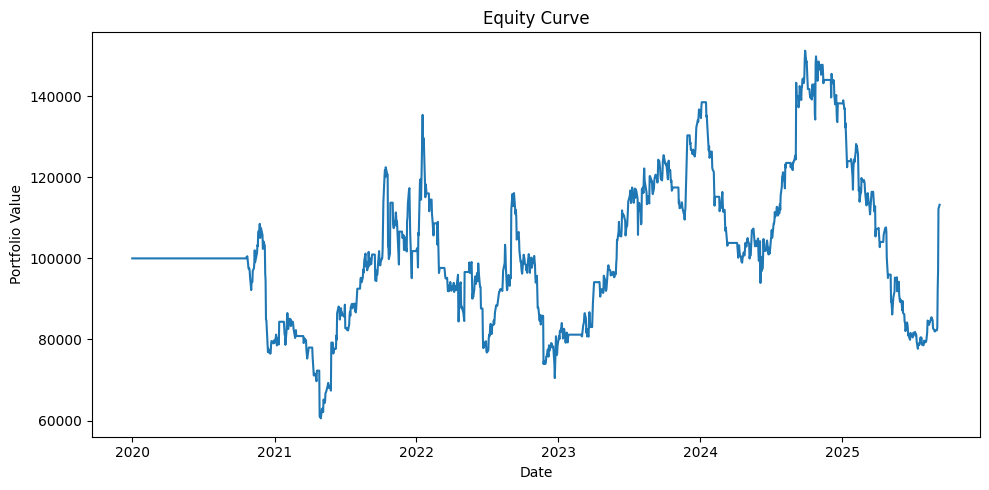

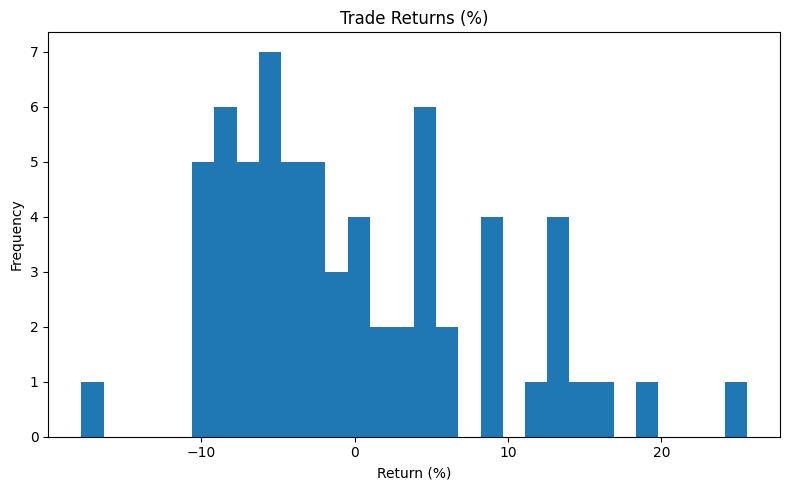

In [25]:
plot_equity_curve(equity_df)
plot_trade_returns_hist(trades_df)
